set the imports

In [3]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import mplfinance as mpf
import yfinance as yf
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from talib import abstract
# add base to the modules
from indicators import indicators as ind
from indicators import normalize as nor
from matplotlib import pyplot as plt
from typing import Union, Tuple
import math

# plt.style.use('dark_background')
%matplotlib inline

### Set the symbol

In [4]:
symbol = "DIA"

In [5]:
def load_ticker(sym, period="5y", interval="1d"):
    spy = yf.Ticker(sym)
    return spy.history(period, interval).reset_index()

### load ticker function

In [6]:
df = load_ticker(symbol)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1259 non-null   datetime64[ns]
 1   Open          1259 non-null   float64       
 2   High          1259 non-null   float64       
 3   Low           1259 non-null   float64       
 4   Close         1259 non-null   float64       
 5   Volume        1259 non-null   int64         
 6   Dividends     1259 non-null   float64       
 7   Stock Splits  1259 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 78.8 KB


## Plot the data to get an idea of the shape

<Figure size 864x864 with 0 Axes>

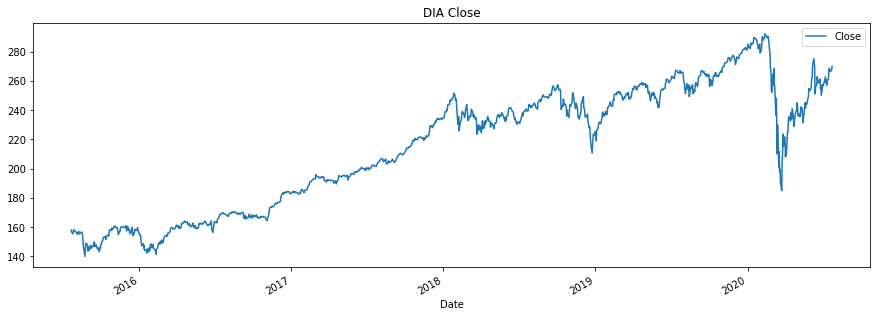

In [7]:
plt.figure(figsize=(12,12))
# plot the chart
df.plot(x="Date", y='Close', kind="line", title=f"{symbol} Close", figsize=(15,5))
plt.legend(loc="best")

In [8]:
def normalize_frame(df: pd.DataFrame) -> pd.DataFrame:
    max_v: np.Float = None
    min_v: np.Float = None
    for col in df.columns:
        max_v = df[col].max() if max_v is None else max(max_v, df[col].max())
        min_v = df[col].min() if min_v is None else min(min_v, df[col].min())

    return (df - min_v) / (max_v - min_v) 

In [9]:
def create_image(frames: list, label, mirror=int) -> tuple:
    idf: pd.DataFrame = None
    columns = []
    for frame in frames:
        # normalize the price-relative data across
        norm_df = normalize_frame(frame)
        if idf is None:
            idf = pd.DataFrame(index=norm_df.index)

        for col in norm_df.columns:
            columns.append(col)
            a = norm_df[col].to_numpy()
            pc = nor.min_max(nor.zscore(a)) * 2 - 1
            idf[col + '_g'] = np.where(pc > 0, pc * a + (1. - a), 0.0)
            idf[col + '_r'] = np.where(pc < 0, -pc * a + (1. - a), 0.0)
            idf[col + '_b'] = a

    idf = idf.dropna().reset_index(drop=True)
    # image h x w = window size x number of features. 3 = rgb values
    img1 = np.zeros((len(idf), len(columns), 3))
    for i, row in idf.iterrows():
        vals = []
        for col in columns:
            vals.append((row[col+'_r'], row[col+'_g'], row[col+'_b']))
        img1[i] = tuple(vals)
    # mirror
    if mirror > 0:
        img_len = len(img1)
        for i in range(0, mirror):
            img1 = np.concatenate((img1, [img1[img_len - i - 1]]))

    # return everything but the first row as the first low has no RGB data
    return img1, label

In [10]:
def plot_images(frames: list, labels, start = 0, window=80, mirror=20, columns = 1, rows = 1, figsize=(16,16)):
    fig = plt.figure(figsize=figsize)
    for i in range(0, columns * rows):
        s = i + start
        e = i + start + window
        plot_frames = []
        for frame in frames:
            plot_frames.append(frame[s:e])
        if labels is not None:
            im_array, label = create_image(plot_frames, labels[e], mirror)
            fig.add_subplot(rows, columns, i+1, title=str(label))
        else:
            im_array, _ = create_image(plot_frames, None, mirror)
            fig.add_subplot(rows, columns, i+1)
        plt.imshow(im_array)
    plt.show()

## Price Indicators
Bollinger Bands, Keltner Channels, EMA, and SMA values

In [11]:
df['Mid'] = ind.mid(df['Open'].values, df['Close'].values)

use a baseline to normalize all price based indicators relative to

In [12]:
baseline = ind.sma(df['Mid'], 200)

### Basic Trend Indicators

EMA, SMA, and linear regression

In [13]:
periods = tuple(range(3,53))

In [14]:
def price_indicators(df: pd.DataFrame, periods: tuple, baseline: np.array) -> pd.DataFrame:
    f = pd.DataFrame(index=df.index)
    for ind_str in ['Open', 'High', 'Low', 'Close', 'Mid']:
        if baseline is not None:
            f[ind_str] = (df[ind_str] - baseline) / ((df[ind_str] + baseline) / 2)
        else:
            f[ind_str] = df[ind_str]

    # numpy-ize
    o = f['Open'].to_numpy()
    h = f['High'].to_numpy()
    l = f['Low'].to_numpy()
    c = f['Close'].to_numpy()
    m = f['Mid'].to_numpy()
    # loop over periods and apply standard indicators 
    for i in periods:
        # EMAs
        f[f'EMA_MID_{i}'] = ind.ema(m, i)
        f[f'EMA_OPEN_{i}'] = ind.ema(o, i)
        f[f'EMA_CLOSE_{i}'] = ind.ema(c, i)
        # linear regression
        # f[f'LREG_MID_{i}'] = ind.rolling_lin(m, i)
        # SMAs
        f[f'SMA_MID_{i}'] = ind.sma(m, i)
        f[f'SMA_OPEN_{i}'] = ind.sma(o, i)
        f[f'SMA_CLOSE_{i}'] = ind.sma(c, i)
        # BBANDs and Keltner channels
        bb2u, _, bb2l = ind.bbands(c, i, 2.)
        bb3u, _, bb3l = ind.bbands(c, i, 3.)
        ku, kl, _ = ind.keltner_channels(h, l, c, i)
        f[f'BB3U_{i}'] = bb3u
        f[f'BB2U_{i}'] = bb2u
        f[f'KELU_{i}'] = ku
        f[f'KELL_{i}'] = kl
        f[f'BB2L_{i}'] = bb2l
        f[f'BB3L_{i}'] = bb3l

    return f

In [15]:
price_df = price_indicators(df, periods, baseline)

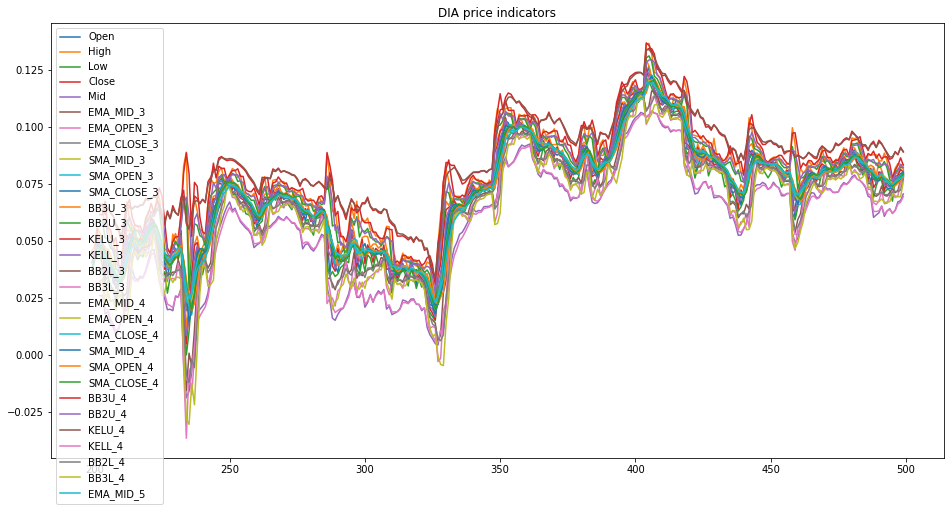

In [16]:
price_df[price_df.columns[:30]].head(500).plot(title=f"{symbol} price indicators", figsize=(16,8))

In [17]:
cols = []
for col in ['BB3U']:
    for i in periods: 
        cols.append(f'{col}_{i}')
for col in ['BB3L']:
    for i in periods: 
        cols.append(f'{col}_{i}')
for col in ['BB2U']:
    for i in periods: 
        cols.append(f'{col}_{i}')
for col in ['BB2L']:
    for i in periods: 
        cols.append(f'{col}_{i}')
for col in ['EMA_MID']:
    for i in periods: 
        cols.append(f'{col}_{i}')
for col in ['SMA_MID']:
    for i in periods: 
        cols.append(f'{col}_{i}')
for col in ['KELU']:
    for i in periods: 
        cols.append(f'{col}_{i}')
for col in ['KELL']:
    for i in periods: 
        cols.append(f'{col}_{i}')
len(cols)

400

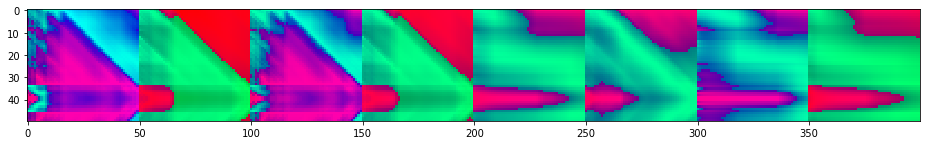

In [18]:
plot_images([price_df[cols]], None, start=200+periods[-1], window=40, mirror=10, columns=1, rows=1, figsize=(16,4))

In [19]:
vol_baseline = ind.sma(df['Volume'], 200)

In [24]:
def vol_indicators(df: pd.DataFrame, periods: tuple, vol_baseline: np.array) -> pd.DataFrame:
    f = pd.DataFrame(index=df.index)
    f['Volume'] = df['Volume'] - vol_baseline
    v = df['Volume'].to_numpy().astype(np.float)
    # loop over periods and apply standard indicators 
    for i in periods:
        f[f'VOL_SMA_{i}'] = ind.sma(v, i) - vol_baseline
        f[f'VOL_EMA_{i}'] = ind.sma(v, i) - vol_baseline
    return normalize_frame(f)

In [25]:
vol_df = vol_indicators(df, periods, vol_baseline)

In [ ]:
cols = []
for col in ['VOL_SMA']:
    for i in periods: 
        cols.append(f'{col}_{i}')
for col in ['VOL_EMA']:
    for i in periods: 
        cols.append(f'{col}_{i}')
len(cols)

In [ ]:
plot_images([vol_df[cols]], None, start=200+periods[-1], window=40, mirror=10, columns=1, rows=1, figsize=(16,4))

In [26]:
def bar(df: pd.DataFrame, periods: tuple) -> pd.DataFrame:
    f = df[['Open', 'High', 'Low', 'Close']]
    # top wave
    f['OPEN_V_CLOSE'] = df['Low'] - df['Mid']
    f['HIGH_V_LOW'] = df['High'] - df['Low']
    # numpy-ize
    o = df['Open'].to_numpy()
    h = df['High'].to_numpy()
    l = df['Low'].to_numpy()
    c = df['Close'].to_numpy()
    m = df['Mid'].to_numpy()
    v = df['Volume'].to_numpy().astype(np.float)
    # loop over periods and apply standard indicators 
    for i in periods:
        # EMAs
        df[f'EMA_MID_{i}'] = ind.ema(m, i)
        df[f'EMA_OPEN_{i}'] = ind.ema(o, i)
        df[f'EMA_CLOSE_{i}'] = ind.ema(c, i)
        # linear regression
        df[f'LREG_MID_{i}'] = ind.rolling_lin(m, i)
        # SMAs
        df[f'SMA_MID_{i}'] = ind.sma(m, i)
        df[f'SMA_OPEN_{i}'] = ind.sma(o, i)
        df[f'SMA_CLOSE_{i}'] = ind.sma(c, i)
        # BBANDs and Keltner channels
        bb2u, _, bb2l = ind.bbands(c, i, 2.)
        bb3u, _, bb3l = ind.bbands(c, i, 3.)
        ku, kl, _ = ind.keltner_channels(h, l, c, i)
        df[f'BB3U_{i}'] = bb3u
        df[f'BB2U_{i}'] = bb2u
        df[f'KELU_{i}'] = ku
        df[f'KELL_{i}'] = kl
        df[f'BB2L_{i}'] = bb2l
        df[f'BB3L_{i}'] = bb3l
        # BBANDs diff
        df[f'BBAND2_DIFF_{i}'] = bb2u - bb2l
        df[f'BBAND3_DIFF_{i}'] = bb3u - bb3l
        # BBANDs vs price
        df[f'BBAND2U_DIFF_{i}'] = bb2u - h
        df[f'BBAND2L_DIFF_{i}'] = l - bb2l
        # regression slope
        df[f'LREGSL_{i}'] = ind.rolling_lin_slope(m, i)
        # candle stick
        df[f'OPEN_V_CLOSE_SMA_{i}'] = ind.sma(df['OPEN_V_CLOSE'].to_numpy(), i)
        df[f'HIGH_V_LOW_SMA_{i}'] = ind.sma(df['HIGH_V_LOW'].to_numpy(), i)
        # # volume
        # df[f'VOL_{i}'] = ind.sma(v, i)
        # atr
        df[f'ATR_{i}'] = ind.atr(h, l, c, i)
        # adx
        df[f'ADX_{i}'] = ind.adx(h, l, c, i)

    # oscilators
    pre = periods[0]
    for i in range(1,len(periods)):
        df[f'ADOSC_{periods[i]}'] = ind.adosc(h, l, c, v, pre, periods[i])
        df[f'EMA_CD_{periods[i]}'] = ind.ema(m, pre) - ind.ema(m, periods[i])
        pre = periods[i]

    return df

100

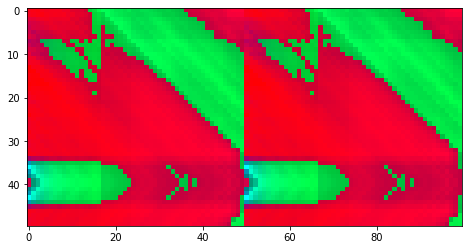

In [27]:
plot_images([vol_df[cols]], None, start=200+periods[-1], window=40, mirror=10, columns=1, rows=1, figsize=(16,4))

In [ ]:
def bar(df: pd.DataFrame, periods: tuple) -> pd.DataFrame:
    f = df[['Open', 'High', 'Low', 'Close']]
    # top wave
    f['OPEN_V_CLOSE'] = df['Low'] - df['Mid']
    f['HIGH_V_LOW'] = df['High'] - df['Low']
    # numpy-ize
    o = df['Open'].to_numpy()
    h = df['High'].to_numpy()
    l = df['Low'].to_numpy()
    c = df['Close'].to_numpy()
    m = df['Mid'].to_numpy()
    v = df['Volume'].to_numpy().astype(np.float)
    # loop over periods and apply standard indicators 
    for i in periods:
        # EMAs
        df[f'EMA_MID_{i}'] = ind.ema(m, i)
        df[f'EMA_OPEN_{i}'] = ind.ema(o, i)
        df[f'EMA_CLOSE_{i}'] = ind.ema(c, i)
        # linear regression
        df[f'LREG_MID_{i}'] = ind.rolling_lin(m, i)
        # SMAs
        df[f'SMA_MID_{i}'] = ind.sma(m, i)
        df[f'SMA_OPEN_{i}'] = ind.sma(o, i)
        df[f'SMA_CLOSE_{i}'] = ind.sma(c, i)
        # BBANDs and Keltner channels
        bb2u, _, bb2l = ind.bbands(c, i, 2.)
        bb3u, _, bb3l = ind.bbands(c, i, 3.)
        ku, kl, _ = ind.keltner_channels(h, l, c, i)
        df[f'BB3U_{i}'] = bb3u
        df[f'BB2U_{i}'] = bb2u
        df[f'KELU_{i}'] = ku
        df[f'KELL_{i}'] = kl
        df[f'BB2L_{i}'] = bb2l
        df[f'BB3L_{i}'] = bb3l
        # BBANDs diff
        df[f'BBAND2_DIFF_{i}'] = bb2u - bb2l
        df[f'BBAND3_DIFF_{i}'] = bb3u - bb3l
        # BBANDs vs price
        df[f'BBAND2U_DIFF_{i}'] = bb2u - h
        df[f'BBAND2L_DIFF_{i}'] = l - bb2l
        # regression slope
        df[f'LREGSL_{i}'] = ind.rolling_lin_slope(m, i)
        # candle stick
        df[f'OPEN_V_CLOSE_SMA_{i}'] = ind.sma(df['OPEN_V_CLOSE'].to_numpy(), i)
        df[f'HIGH_V_LOW_SMA_{i}'] = ind.sma(df['HIGH_V_LOW'].to_numpy(), i)
        # # volume
        # df[f'VOL_{i}'] = ind.sma(v, i)
        # atr
        df[f'ATR_{i}'] = ind.atr(h, l, c, i)
        # adx
        df[f'ADX_{i}'] = ind.adx(h, l, c, i)

    # oscilators
    pre = periods[0]
    for i in range(1,len(periods)):
        df[f'ADOSC_{periods[i]}'] = ind.adosc(h, l, c, v, pre, periods[i])
        df[f'EMA_CD_{periods[i]}'] = ind.ema(m, pre) - ind.ema(m, periods[i])
        pre = periods[i]

    return df

In [ ]:
def bar(df: pd.DataFrame, periods: tuple) -> pd.DataFrame:
    f = df[['Open', 'High', 'Low', 'Close']]
    # top wave
    f['OPEN_V_CLOSE'] = df['Low'] - df['Mid']
    f['HIGH_V_LOW'] = df['High'] - df['Low']
    # numpy-ize
    o = df['Open'].to_numpy()
    h = df['High'].to_numpy()
    l = df['Low'].to_numpy()
    c = df['Close'].to_numpy()
    m = df['Mid'].to_numpy()
    v = df['Volume'].to_numpy().astype(np.float)
    # loop over periods and apply standard indicators 
    for i in periods:
        # EMAs
        df[f'EMA_MID_{i}'] = ind.ema(m, i)
        df[f'EMA_OPEN_{i}'] = ind.ema(o, i)
        df[f'EMA_CLOSE_{i}'] = ind.ema(c, i)
        # linear regression
        df[f'LREG_MID_{i}'] = ind.rolling_lin(m, i)
        # SMAs
        df[f'SMA_MID_{i}'] = ind.sma(m, i)
        df[f'SMA_OPEN_{i}'] = ind.sma(o, i)
        df[f'SMA_CLOSE_{i}'] = ind.sma(c, i)
        # BBANDs and Keltner channels
        bb2u, _, bb2l = ind.bbands(c, i, 2.)
        bb3u, _, bb3l = ind.bbands(c, i, 3.)
        ku, kl, _ = ind.keltner_channels(h, l, c, i)
        df[f'BB3U_{i}'] = bb3u
        df[f'BB2U_{i}'] = bb2u
        df[f'KELU_{i}'] = ku
        df[f'KELL_{i}'] = kl
        df[f'BB2L_{i}'] = bb2l
        df[f'BB3L_{i}'] = bb3l
        # BBANDs diff
        df[f'BBAND2_DIFF_{i}'] = bb2u - bb2l
        df[f'BBAND3_DIFF_{i}'] = bb3u - bb3l
        # BBANDs vs price
        df[f'BBAND2U_DIFF_{i}'] = bb2u - h
        df[f'BBAND2L_DIFF_{i}'] = l - bb2l
        # regression slope
        df[f'LREGSL_{i}'] = ind.rolling_lin_slope(m, i)
        # candle stick
        df[f'OPEN_V_CLOSE_SMA_{i}'] = ind.sma(df['OPEN_V_CLOSE'].to_numpy(), i)
        df[f'HIGH_V_LOW_SMA_{i}'] = ind.sma(df['HIGH_V_LOW'].to_numpy(), i)
        # # volume
        # df[f'VOL_{i}'] = ind.sma(v, i)
        # atr
        df[f'ATR_{i}'] = ind.atr(h, l, c, i)
        # adx
        df[f'ADX_{i}'] = ind.adx(h, l, c, i)

    # oscilators
    pre = periods[0]
    for i in range(1,len(periods)):
        df[f'ADOSC_{periods[i]}'] = ind.adosc(h, l, c, v, pre, periods[i])
        df[f'EMA_CD_{periods[i]}'] = ind.ema(m, pre) - ind.ema(m, periods[i])
        pre = periods[i]

    return df

In [88]:
# add the price indicators to the dataframe
df = add_base_indicators(df, periods)
print(df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Mid', 'EMA_3',
       ...
       'BBAND2U_DIFF_30', 'BBAND2L_DIFF_30', 'LREGSL_30',
       'OPEN_V_CLOSE_SMA_30', 'HIGH_V_LOW_SMA_30', 'VOL_30', 'ATR_30',
       'ADX_30', 'ADOSC_30', 'EMA_CD_30'],
      dtype='object', length=918)


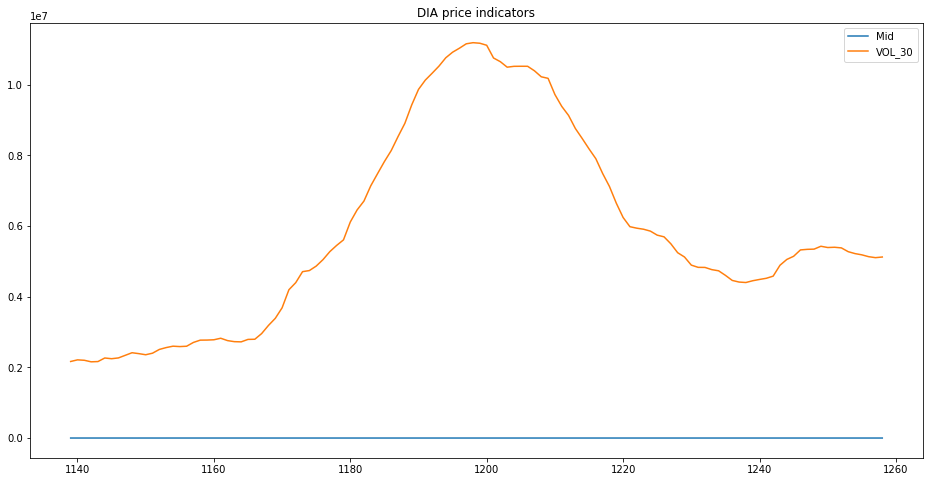

In [89]:
df[['Mid', 'VOL_30']].tail(WINDOW*2).plot(kind="line", title=f"{symbol} price indicators", figsize=(16,8))

### SAR

In [90]:
sar_accelerations = (.1,.2,.3,.4,.5)

In [91]:
# smoothed sar seperated as it uses a different set of values
def add_sar(df: pd.DataFrame, accelerations: tuple)->pd.DataFrame:
    for i in accelerations:
        df[f'SAR_{i}'] = ind.ema(ind.sar(df['High'], df['Low'], float(i), 1.), int(i*100))
    return df

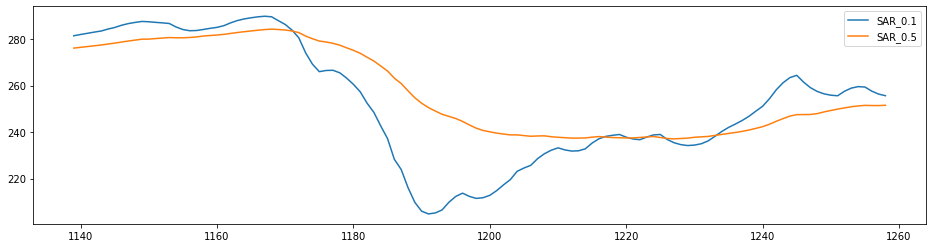

In [92]:
add_sar(df, sar_accelerations)
df[['SAR_0.1', 'SAR_0.5']].tail(WINDOW*2).plot(kind="line", figsize=(16,4))

### BAR indicators
day to day gaps and bar sizes

In [93]:
def add_gap_df(df: pd.DataFrame, periods: tuple) -> pd.DataFrame:
    o = np.delete(df['Open'].to_numpy(), 0)
    c = df['Close'].to_numpy()[:-1]
    gap_pc = (o - c) / c
    gap_up = np.concatenate(([np.nan], np.where(gap_pc > 0, gap_pc, 0.)))
    gap_down = np.concatenate(([np.nan], np.where(gap_pc < 0, gap_pc, 0.)))
    net_gap = gap_up - gap_down
    for i in periods:     
        df[f'GAP_{i}'] = ind.sma(net_gap, i)
    return df

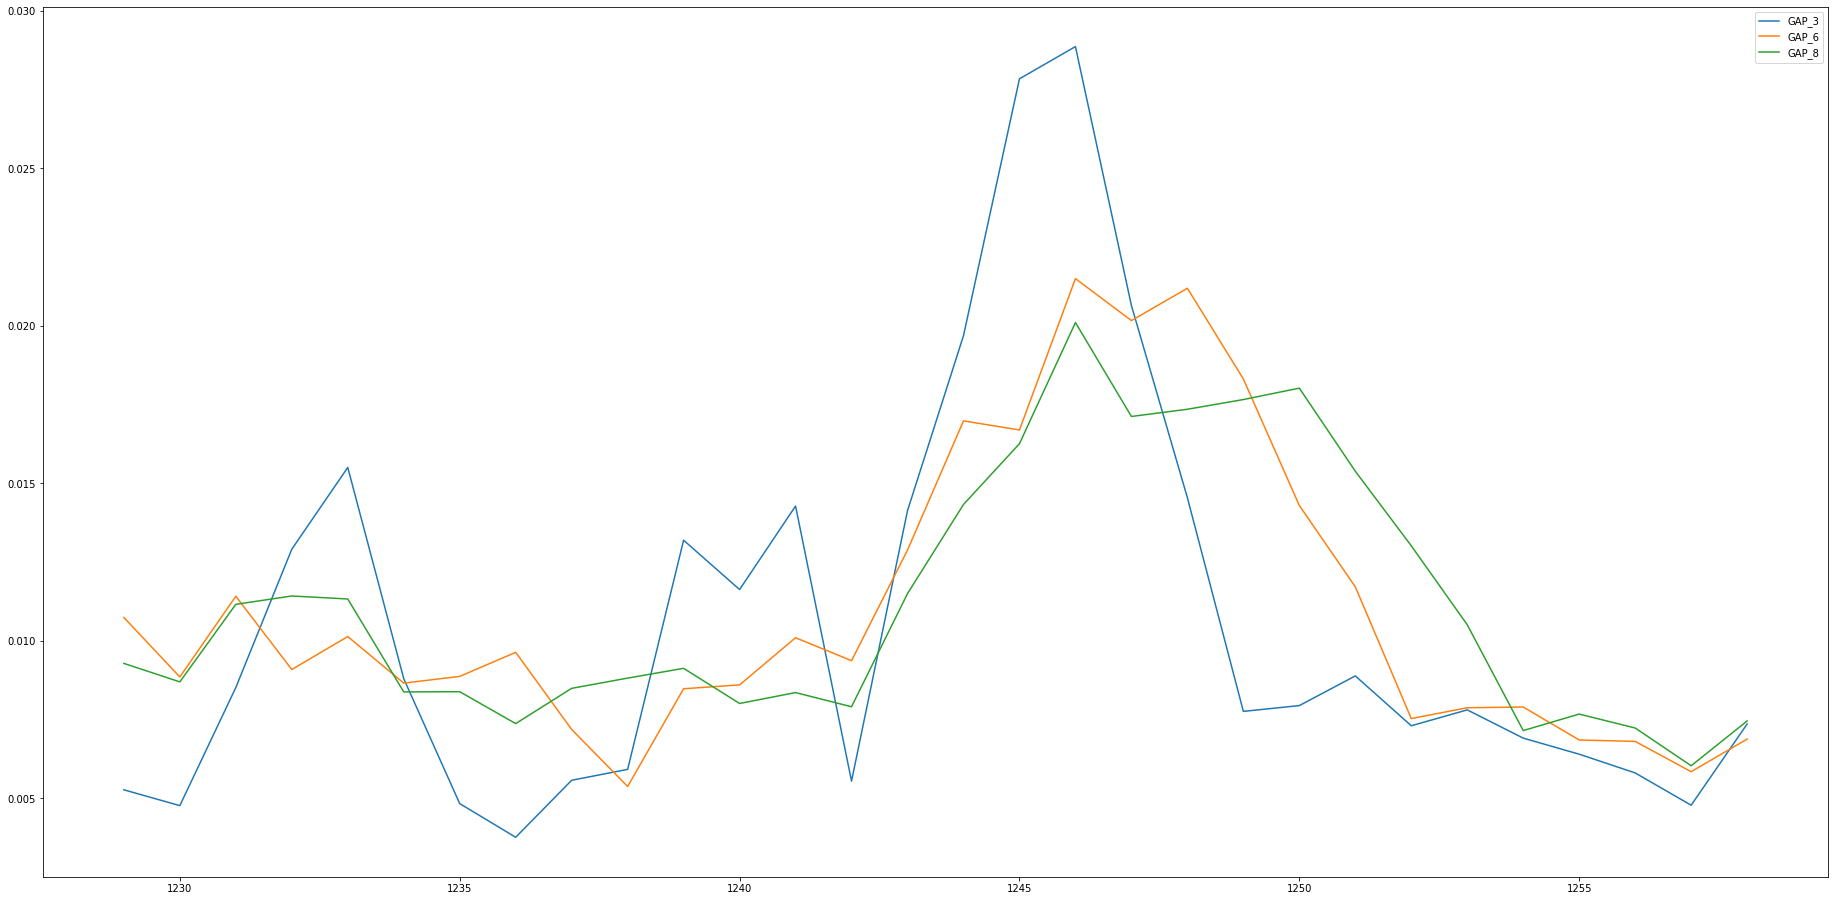

In [96]:
add_gap_df(df, price_periods[:-2])
# plot the dataframe with the indicators
df[['GAP_3', 'GAP_6', 'GAP_8']].tail(30).plot(figsize=(32,16))

### Ease of Movement

In [97]:
def add_eom(df: pd.DataFrame, window:int, periods: Tuple[int])->pd.DataFrame:
    for i in periods:
        df[f'EOME_{i}'] = ind.eome(df['Volume'].to_numpy().astype(np.float), df['Close'].to_numpy(), window, i)
    return df

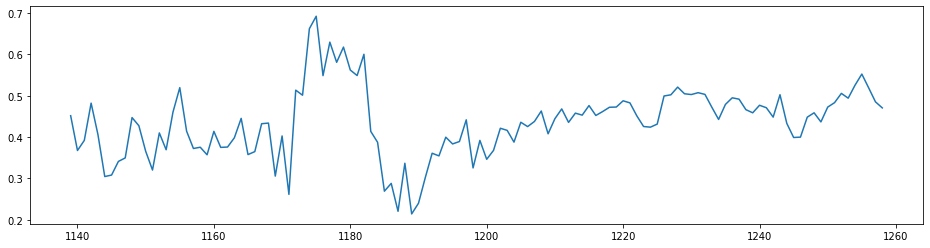

In [99]:
add_eom(df, WINDOW, price_periods[:-2])
# plot ease of movement
df['EOME_3'].tail(WINDOW*2).plot(figsize=(16,4))

### Get Labels

labels will be the rounded average future change

In [62]:
# get average future change percentage 3 days into the future
avg_future_change = ind.apfc(df['Close'], 3, 3)
future_change = discretize(avg_future_change, [-.1, -.05, -0.01, .01, .05, .1, np.inf], [-.1, -.05, -.01, 0, .01, .05, .1])

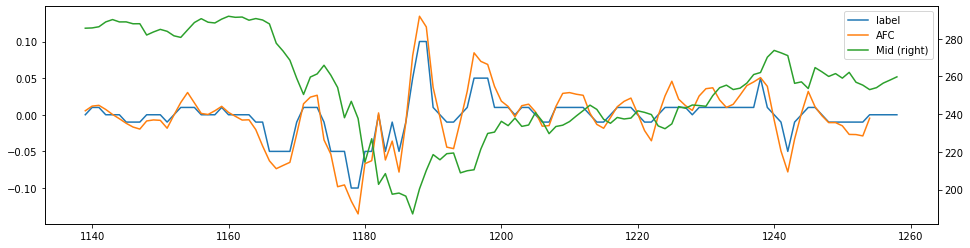

In [63]:
chart = pd.DataFrame()
chart['label'] = future_change
chart['AFC'] = avg_future_change
chart['Mid'] = df['Mid']
chart.tail(WINDOW*2).plot(figsize=(16,4), secondary_y=['Mid'])

### Create images

In [131]:
def create_image(frames: list, label, mirror=int) -> tuple:
    idf: pd.DataFrame = None
    columns = []
    for frame in frames:
        # normalize the price-relative data across
        norm_df = normalize_frame(frame)
        if idf is None:
            idf = pd.DataFrame(index=norm_df.index)

        for col in norm_df.columns:
            columns.append(col)
            a = norm_df[col].to_numpy()
            pc = nor.min_max(nor.zscore(a)) * 2 - 1
            idf[col + '_g'] = np.where(pc > 0, pc * a + (1. - a), 0.0)
            idf[col + '_r'] = np.where(pc < 0, -pc * a + (1. - a), 0.0)
            idf[col + '_b'] = a

    idf = idf.dropna().reset_index(drop=True)
    # image h x w = window size x number of features. 3 = rgb values
    img1 = np.zeros((len(idf), len(columns), 3))
    for i, row in idf.iterrows():
        vals = []
        for col in columns:
            vals.append((row[col+'_r'], row[col+'_g'], row[col+'_b']))
        img1[i] = tuple(vals)
    # mirror
    if mirror > 0:
        img_len = len(img1)
        for i in range(0, mirror):
            img1 = np.concatenate((img1, [img1[img_len - i - 1]]))

    # return everything but the first row as the first low has no RGB data
    return img1, label

In [132]:
start = 100+192
col_len = (
    len(price_df.columns)
    + len(channel_df.columns)
    + len(sar_df.columns)
    + len(bar_df.columns)
    + len(bbd_df.columns)
    + len(gap_df.columns)
    + len(adx_df.columns)
    + len(atr_df.columns)
    + len(lin_slope_df.columns)
    + len(eom_df.columns)
    + len(vol_df.columns))
mirror = int(math.floor(col_len/4))
window = mirror * 3

In [133]:
print(f'x = {col_len}, y={mirror} + {window} = {mirror+window}')

x = 116, y=29 + 87 = 116


In [125]:
start_b = 100+192
col_len_b = (
    len(price_df.columns)
    + len(channel_df.columns)
    + len(sar_df.columns)
    + len(bar_df.columns)
    + len(gap_df.columns)
    + len(adx_df.columns)
    + len(atr_df.columns)
    + len(eom_df.columns)
    + len(vol_df.columns))
mirror_b = int(math.floor(col_len/4))
window_b = mirror * 3

In [134]:
# plot the images
from matplotlib import image

columns = 4
rows = 4
cnt = 0


<Figure size 1152x1152 with 0 Axes>

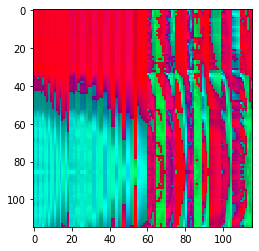

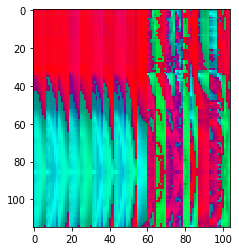

In [126]:
for i in range(0, columns * rows):
    s = i + start_b
    e = i + start_b + window_b
    im_array, label = create_image(
        [
            price_df_b[s:e], 
            channel_df_b[s:e], 
            sar_df[s:e], 
            bar_df[s:e], 
            gap_df[s:e],
            adx_df[s:e], 
            atr_df[s:e], 
            eom_df[s:e], 
            vol_df[s:e]
        ], future_change[e], mirror)
    fig.add_subplot(rows, columns, i+1, title=str(label))
    plt.imshow(im_array)
    # image.imsave(os.path.join(os.getcwd(), "..", "data", f"{label}_{symbol}.png"), im_array)
plt.show()

### Create images for the entire dataset

use multiprocessing to speed up the export

In [243]:
from pathlib import Path
from time import time
from multiprocessing import Pool, Queue

In [244]:
def worker(queue: Queue):
    print(f'{os.getpid()} worker started')
    while True:
        # get and block
        item = queue.get(True)
        if item == -1:
            # stop the worker if we recieved None, signaling queue is empty
            print(f'{os.getpid()} worker finished')
            return
        img, label = create_image(item[0], item[1], item[2])
        fname = item[4] / f"{item[1]}_{item[5]}_{item[3]}.png"
        image.imsave(fname, img)
        print(f'saved {fname}')

In [245]:
workers = 8
tasks = {}
start = 100+192

# set the data dir
data_dir = Path(os.getcwd()) / '..' / 'data' / 'img'

# create dir if note exists
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)
    print(f'created dir: {data_dir}')

q = Queue(workers)

# create worker pool
p = Pool(workers, worker, (q,))

for i in range(start, len(df)-window-4):
    s = i
    e = i + window
    # put and block
    q.put(([
                price_df[s:e], 
                channel_df[s:e], 
                sar_df[s:e], 
                bar_df[s:e], 
                bbd_df[s:e], 
                gap_df[s:e],
                adx_df[s:e], 
                atr_df[s:e], 
                lin_slope_df[s:e], 
                eom_df[s:e], 
                vol_df[s:e]
            ], future_change[e], mirror, df['Date'].at[e].isoformat(), data_dir, symbol), True)

for i in range(0, workers):
    q.put(-1, True)

print('Done')

ooks/../data/img/0.0_DIA_2019-08-08T00:00:00.png
saved /Users/eric/Projects/stonks/ml/notebooks/../data/img/-0.01_DIA_2019-08-09T00:00:00.png
saved /Users/eric/Projects/stonks/ml/notebooks/../data/img/-0.01_DIA_2019-08-12T00:00:00.png
saved /Users/eric/Projects/stonks/ml/notebooks/../data/img/0.0_DIA_2019-08-14T00:00:00.png
saved /Users/eric/Projects/stonks/ml/notebooks/../data/img/-0.01_DIA_2019-08-13T00:00:00.png
saved /Users/eric/Projects/stonks/ml/notebooks/../data/img/0.0_DIA_2019-08-15T00:00:00.png
saved /Users/eric/Projects/stonks/ml/notebooks/../data/img/0.01_DIA_2019-08-16T00:00:00.png
saved /Users/eric/Projects/stonks/ml/notebooks/../data/img/0.0_DIA_2019-08-19T00:00:00.png
saved /Users/eric/Projects/stonks/ml/notebooks/../data/img/0.0_DIA_2019-08-20T00:00:00.png
saved /Users/eric/Projects/stonks/ml/notebooks/../data/img/-0.01_DIA_2019-08-21T00:00:00.png
saved /Users/eric/Projects/stonks/ml/notebooks/../data/img/-0.01_DIA_2019-08-22T00:00:00.png
saved /Users/eric/Projects/sto